### <span style="color:teal"> __UNIPARTITE - DISEASE NETWORK ANALYSIS__ 

<span style="color:teal"> In a disease‐centric unipartite genus network, diseases are represented as nodes, and an edge is drawn between two diseases when they share one or more microbial genera with statistically significant associations. This projection is derived from an underlying disease–genus bipartite network, where the intermediate microbial genera serve as the basis for linking diseases. Such a network highlights the similarity in microbial profiles between different diseases, capturing patterns of shared dysbiosis. By focusing on disease–disease connections, it allows us to explore potential comorbidity patterns, identify disease clusters with overlapping microbial signatures, and generate hypotheses about common pathophysiological mechanisms that may be mediated by the gut microbiome. This approach shifts the perspective from individual taxa to the broader relationships between diseases, providing a systems‐level view of microbiome–host interactions.


In [3]:

# LOADING REQUIRED PACKAGES
import pickle
from collections import Counter
import itertools
import json
import powerlaw
from kneed import KneeLocator
import pickle

# NetworkX and Seaborn
from networkx.algorithms import bipartite
import seaborn as sns
from collections import defaultdict

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

import matplotlib.ticker as ticker 

from adjustText import adjust_text
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain  # Louvain community detection (python-louvain)
import textwrap
# Optional: Configure matplotlib to use a specific style or suppress warnings
# plt.style.use('seaborn-whitegrid')  # optional, if you want a consistent style


powerlaw.__version__  # Check the version of powerlaw package

'1.4.4'

In [20]:
# LOADING THE UNIPARTITE DISEASE _GENUS PROJECTION NETWORK
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/bipartite_genus_network.gpickle", "rb") as f:
    B_genus = pickle.load(f)

In [21]:
# Open the JSON file containing disease name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gut_microbiome_project/resources/disease_dict.json", "r") as f:
    disease_dict = json.load(f)

# Load the phenotype mapping JSON
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_classification.json", "r") as f:
    disease_category_by_id = json.load(f)


=== Network Summary ===
Number of nodes: 65
Number of edges: 1930
Degree range: (30.0, 64.0)
Edge weight range: (1.0, 36.0)


/tmp/slurm.4378198/ipykernel_2051644/335558794.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


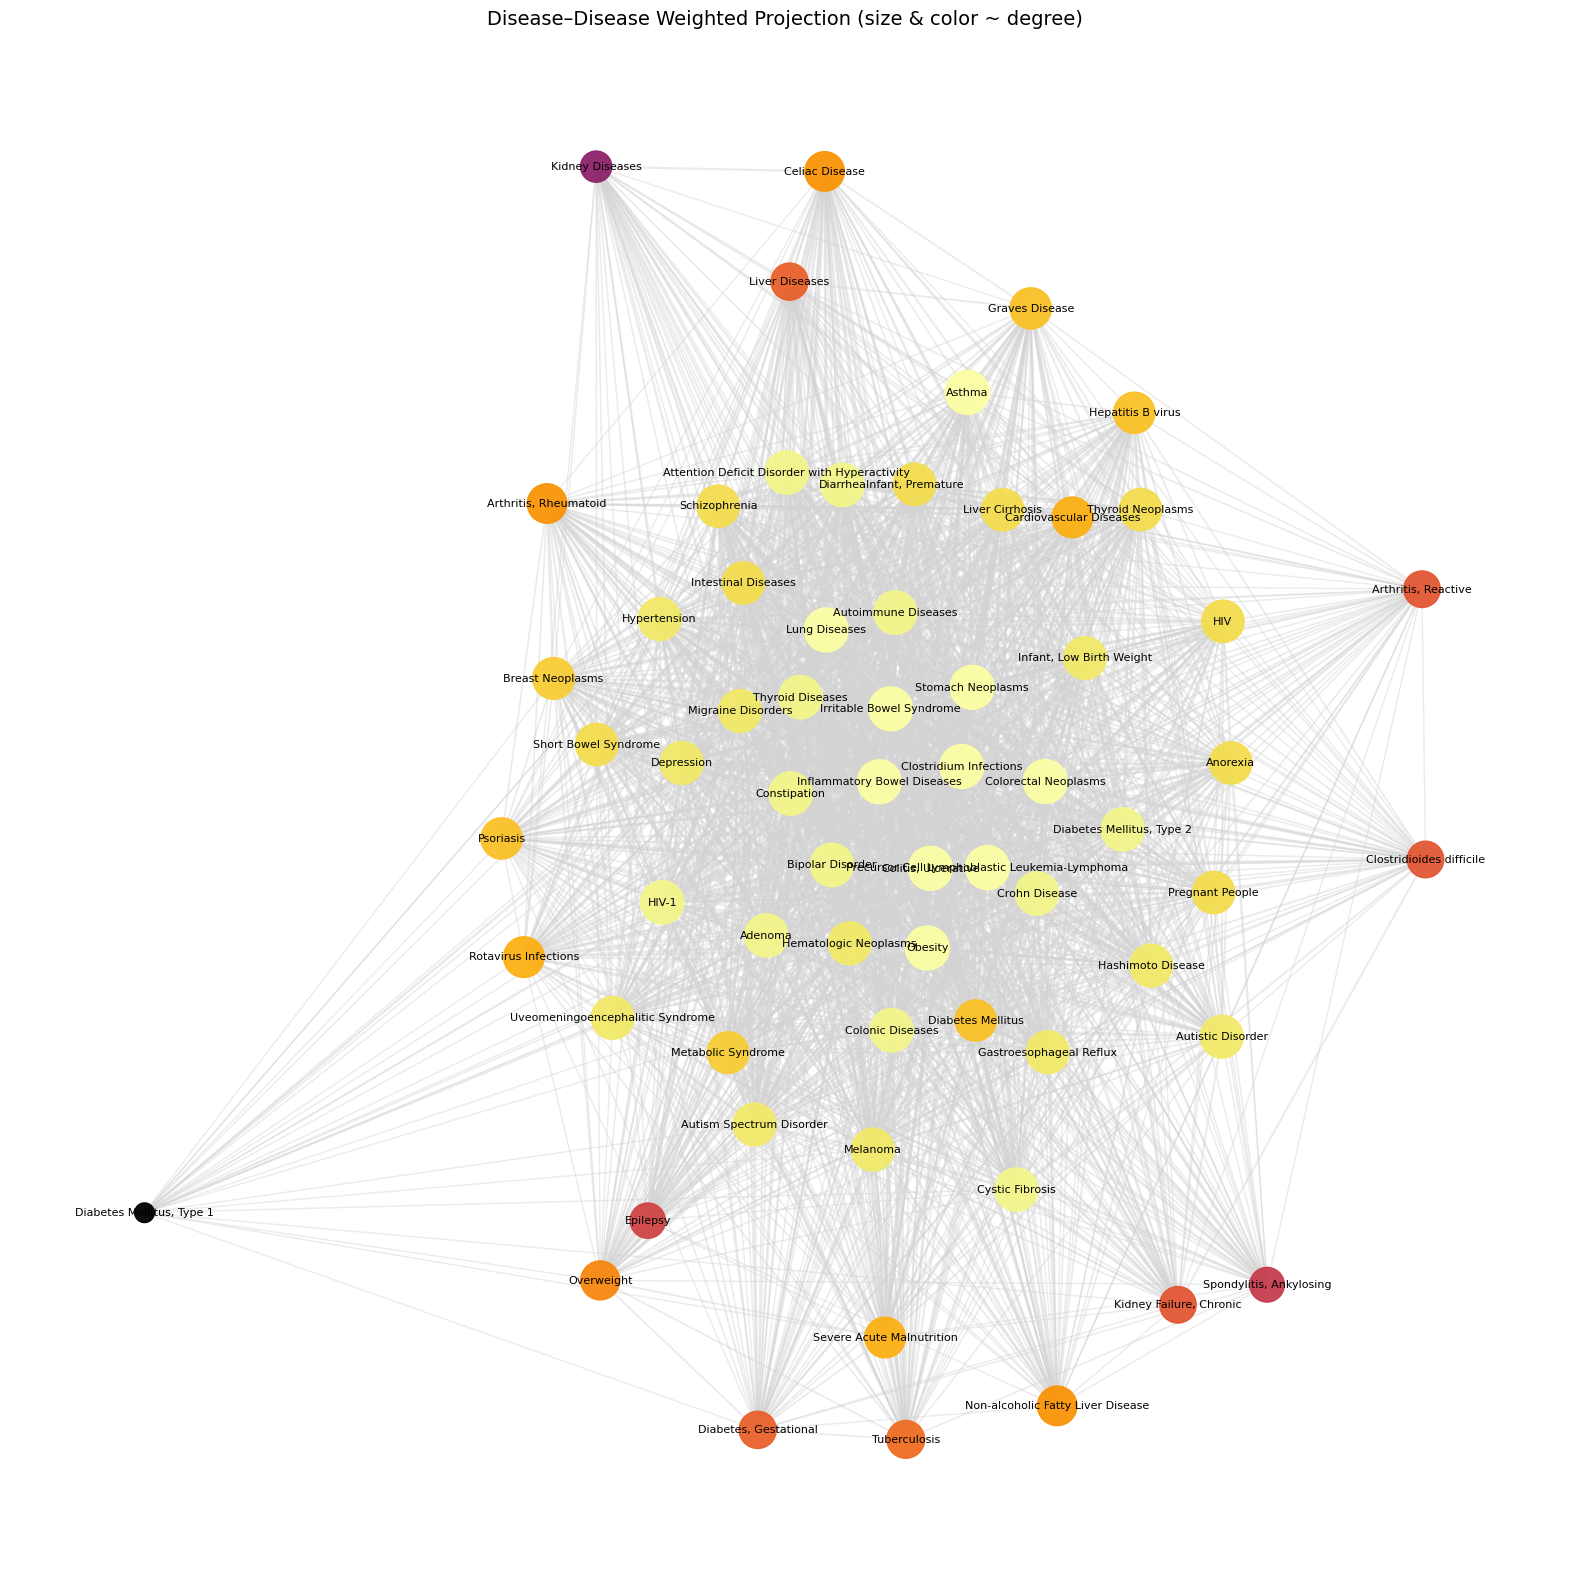

In [22]:
# BIPARTITE DISEASE DIEASE NETWORK
# --- Partitions from B_genus (assumes bipartite attr: 0=diseases, 1=taxa) ---
diseases = {n for n, d in B_genus.nodes(data=True) if d.get("bipartite") == 0}
if not diseases:
    raise ValueError("No disease nodes found with bipartite==0 in B_genus.")

# --- Weighted unipartite projection: disease–disease (weight = shared taxa count) ---
G = bipartite.weighted_projected_graph(B_genus, diseases)

# === Summary stats ===
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (deg_vals.min() if deg_vals.size else None,
                     deg_vals.max() if deg_vals.size else None),
    "Edge weight range": (weights.min() if weights.size else None,
                          weights.max() if weights.size else None)
}
print("=== Network Summary ===")
for k, v in summary.items():
    if isinstance(v, tuple):
        v = tuple(float(x) if x is not None else None for x in v)
    print(f"{k}: {v}")

# --- Layout ---
pos = nx.spring_layout(G, seed=42, k=1.2)

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 200, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Node colors: same normalization → Inferno colormap ---
cmap = cm.get_cmap("inferno")
node_colors = cmap(deg_norm)  # RGBA colors aligned with node order below

# --- Edge widths: normalize weights to [0,1] then map to pixel range ---
if weights.size:
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm
else:
    edge_widths = []

# --- Labels from disease_dict (fallback to code if missing) ---
labels = {n: disease_dict.get(n, str(n)) for n in G.nodes()}

# --- Draw ---
plt.figure(figsize=(20, 20))

# Edges first
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45, edge_color="lightgray")

# Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(G.nodes()),
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.95,
)

# Labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Disease–Disease Weighted Projection (size & color ~ degree)", fontsize=14)
plt.axis("off")
plt.show()


Calculating best minimal value for power law fit
/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/miniforge3/envs/mam_myenv/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/miniforge3/envs/mam_myenv/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


=== Network Summary (Filtered) ===
Number of nodes: 63
Number of edges: 989
Density: 0.5064
Average degree: 31.40
Maximum degree: 56 (node: D003093)
Power-law alpha: 4.12
Power-law xmin: 32.0


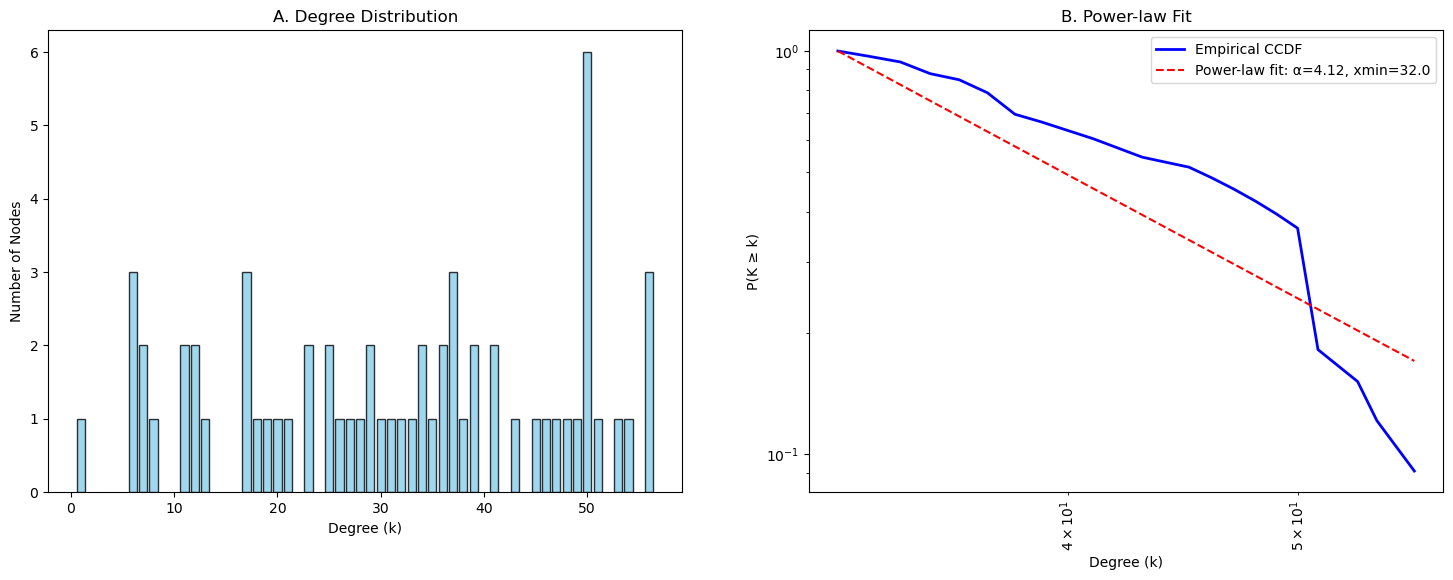

In [23]:
# === User-defined threshold ===
edge_weight_threshold = 5 # change this to your cutoff

# === Step 1: Apply edge weight filtering ===
if edge_weight_threshold > 0:
    G_filtered = nx.Graph()
    for u, v, data in G.edges(data=True):
        weight = data.get("weight", 1)  # default weight = 1 if not present
        if weight >= edge_weight_threshold:
            G_filtered.add_edge(u, v, **data)
else:
    G_filtered = G.copy()

# === Step 2: Degree histogram data ===
degrees = [deg for _, deg in G_filtered.degree()]
unique_deg, counts = np.unique(degrees, return_counts=True)

# === Step 3: Power-law fit for CCDF ===
fit = powerlaw.Fit(degrees, discrete=True)
alpha = fit.alpha
xmin = fit.xmin

# === Step 4: Network layout ===
pos = nx.spring_layout(G_filtered, seed=42, k=2)  # change layout if needed

# === Step 5: Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Panel A: Degree histogram
axes[0].bar(unique_deg, counts, color='skyblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel("Degree (k)")
axes[0].set_ylabel("Number of Nodes")
axes[0].set_title("A. Degree Distribution")

# Panel B: CCDF with power-law fit
# Plot CCDF
fit.plot_ccdf(ax=axes[1], color='blue', linewidth=2, label='Empirical CCDF')
fit.power_law.plot_ccdf(ax=axes[1], color='red', linestyle='--',
                        label=f'Power-law fit: α={alpha:.2f}, xmin={xmin}')

# Force normal numbers on x-axis
#axes[1].set_xscale('linear')
axes[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1].ticklabel_format(style='plain', axis='x')
axes[1].tick_params(axis='x', which='both', labelrotation=90) 

# ✅ Add axis labels
axes[1].set_xlabel("Degree (k)")
axes[1].set_ylabel("P(K ≥ k)")  # CCDF definition

axes[1].legend()
axes[1].set_title("B. Power-law Fit")

# === Step 0: Basic network statistics ===
num_nodes = G_filtered.number_of_nodes()
num_edges = G_filtered.number_of_edges()
density = nx.density(G_filtered)
avg_degree = sum(dict(G_filtered.degree()).values()) / num_nodes if num_nodes > 0 else 0
max_degree_node, max_degree = max(G_filtered.degree(), key=lambda x: x[1]) if num_nodes > 0 else (None, 0)

print("=== Network Summary (Filtered) ===")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Maximum degree: {max_degree} (node: {max_degree_node})")
print(f"Power-law alpha: {alpha:.2f}")
print(f"Power-law xmin: {xmin}")


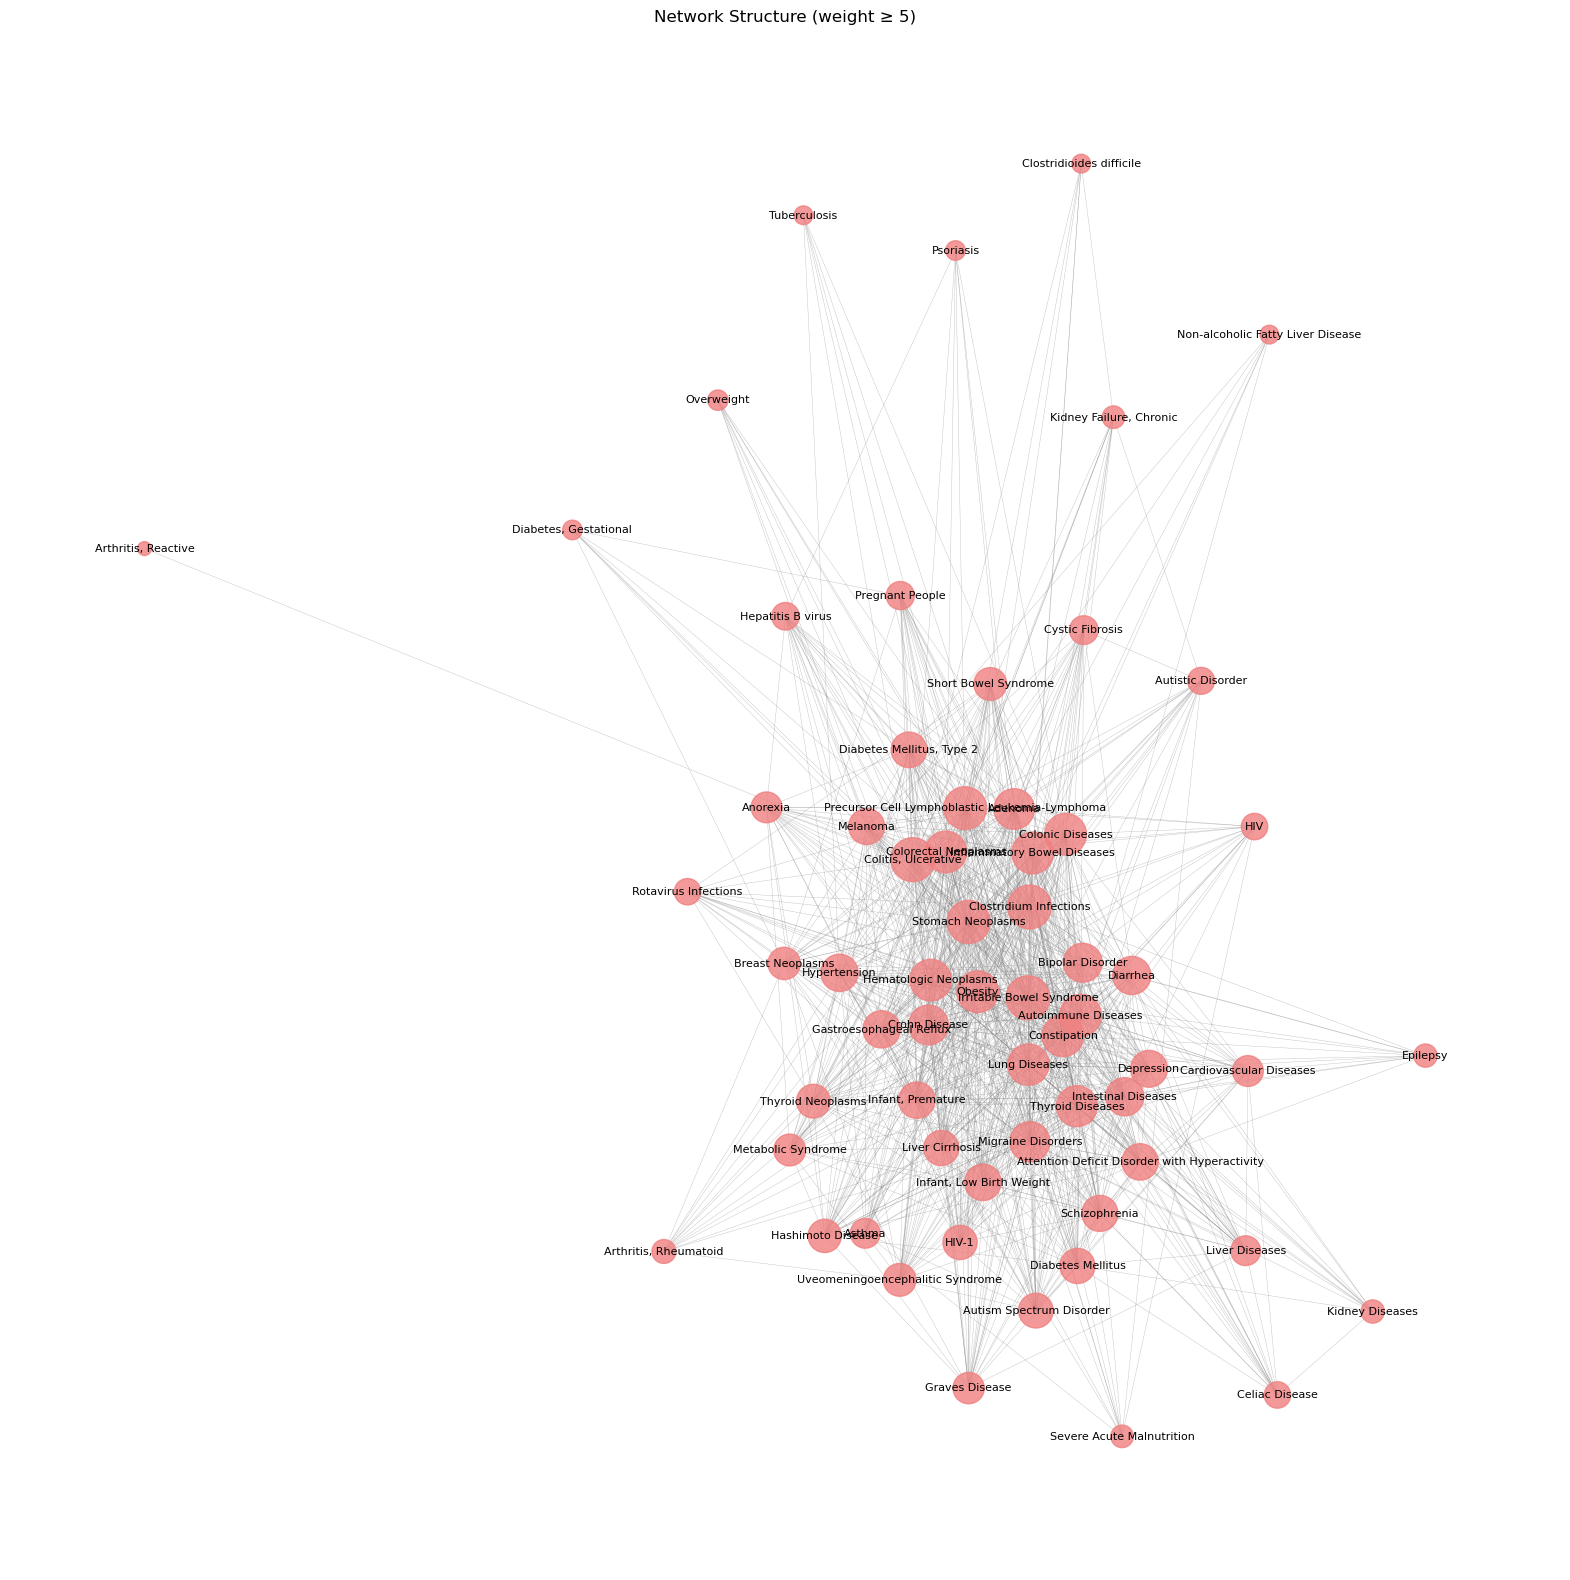

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# If you don't already have pos from a previous cell, compute it here:
pos = nx.spring_layout(G_filtered, seed=42)

# Map node IDs to readable labels from disease_dict
labels = {n: disease_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 100, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Plot ---
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.8)
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8)

plt.title(f"Network Structure (weight ≥ {edge_weight_threshold})")
plt.axis('off')
plt.show()


/tmp/slurm.4378198/ipykernel_2051644/718299592.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


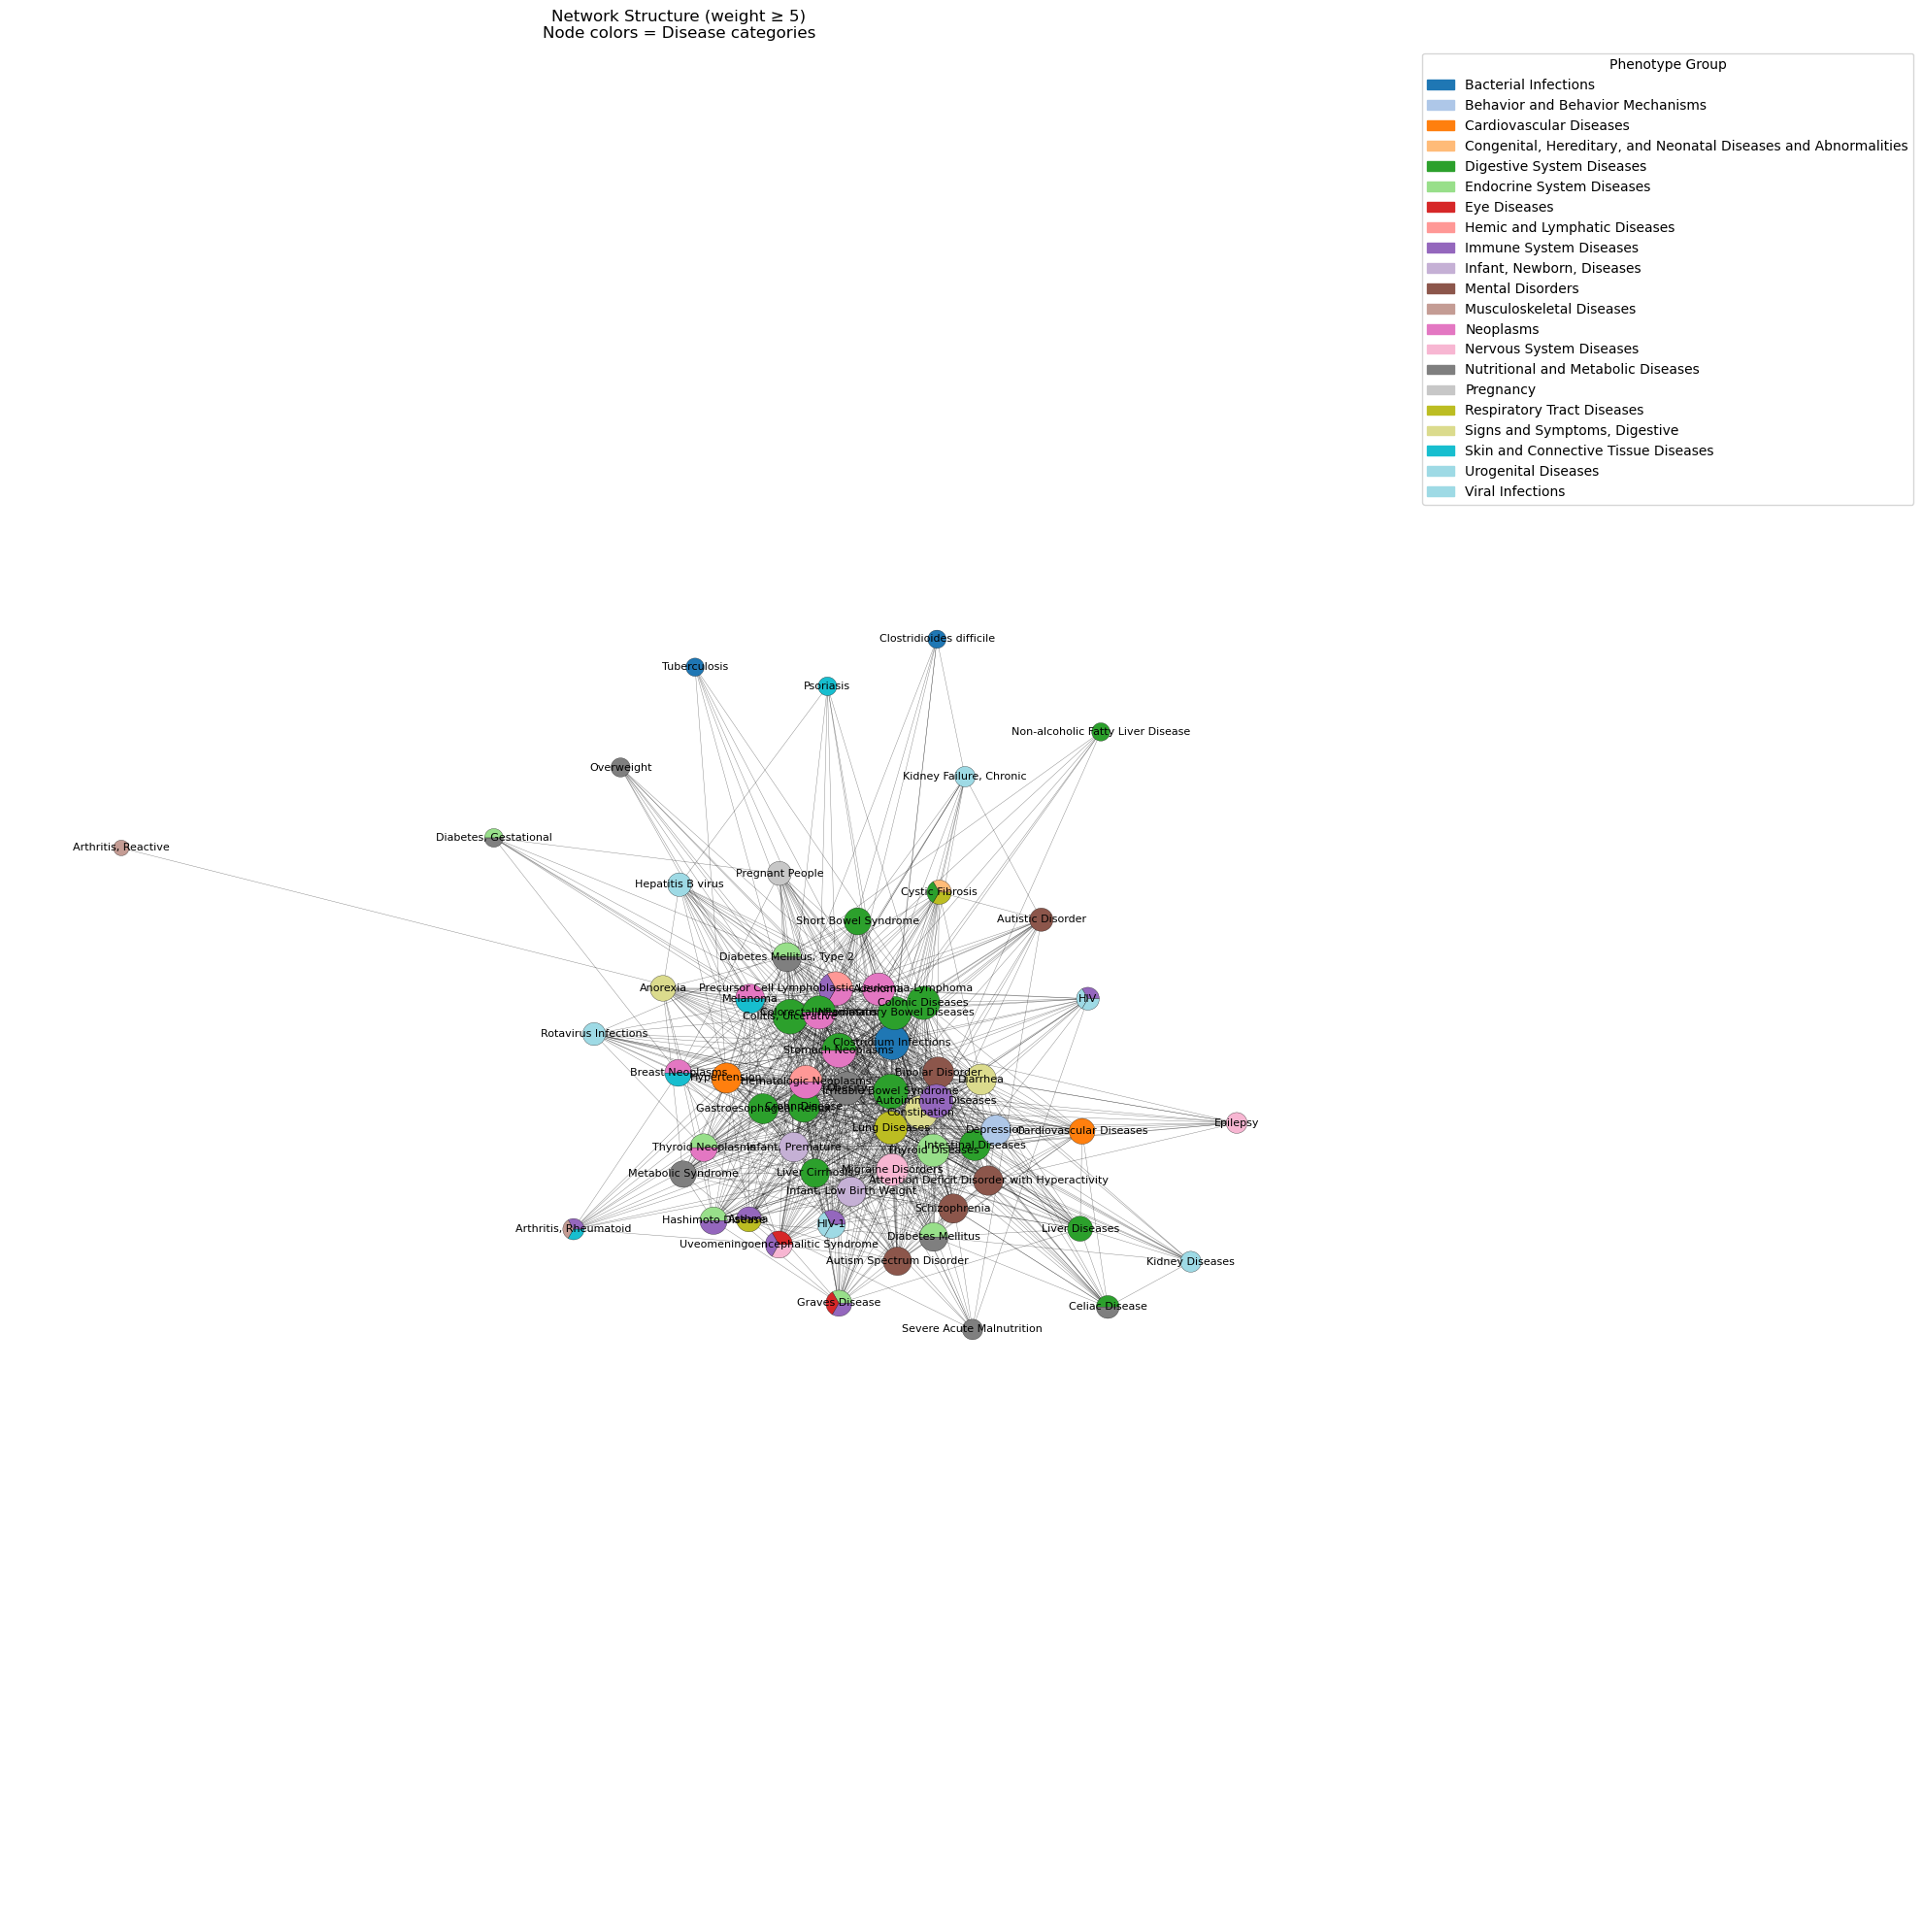

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

# --- Layout & labels ---
pos = nx.spring_layout(G_filtered, seed=42)

# Scale the layout outward without recalculating
scale_factor = 4.0  # Increase for more spacing
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

labels = {n: disease_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node size from degree (AFTER threshold) ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
min_size, max_size = 200, 1000  # points^2 (same convention as networkx)
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Normalize categories per node & collect actually used categories ---
node_cats = {}
for n in G_filtered.nodes():
    cats = disease_category_by_id.get(n, [])
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats

used_categories = sorted({c for cats in node_cats.values() for c in cats})

# --- Color map ONLY for used categories ---
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Figure & axis ---
fig, ax = plt.subplots(figsize=(20, 20))

# Edges first
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, ax=ax)

# Set axis limits from positions (ensures stable size conversion)
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
pad_x = (xs.max() - xs.min()) * 0.10 if xs.size else 0.1
pad_y = (ys.max() - ys.min()) * 0.10 if ys.size else 0.1
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)

# Keep circles round
ax.set_aspect('equal', adjustable='datalim')

# Helper: convert node size (points^2) -> radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)          # points
    r_px = r_pts * (fig.dpi / 72.0)             # pixels
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Draw nodes as pie slices
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.2, zorder=2
        )
        ax.add_patch(wedge)

# Labels on top
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8, ax=ax)

ax.set_title(f"Network Structure (weight ≥ {edge_weight_threshold})\nNode colors = Disease categories")
ax.axis('off')

# Legend ONLY for used categories (Unclassified shows up only if present)
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(handles=legend_handles, title="Phenotype Group", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


/tmp/slurm.4378198/ipykernel_2051644/578921687.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


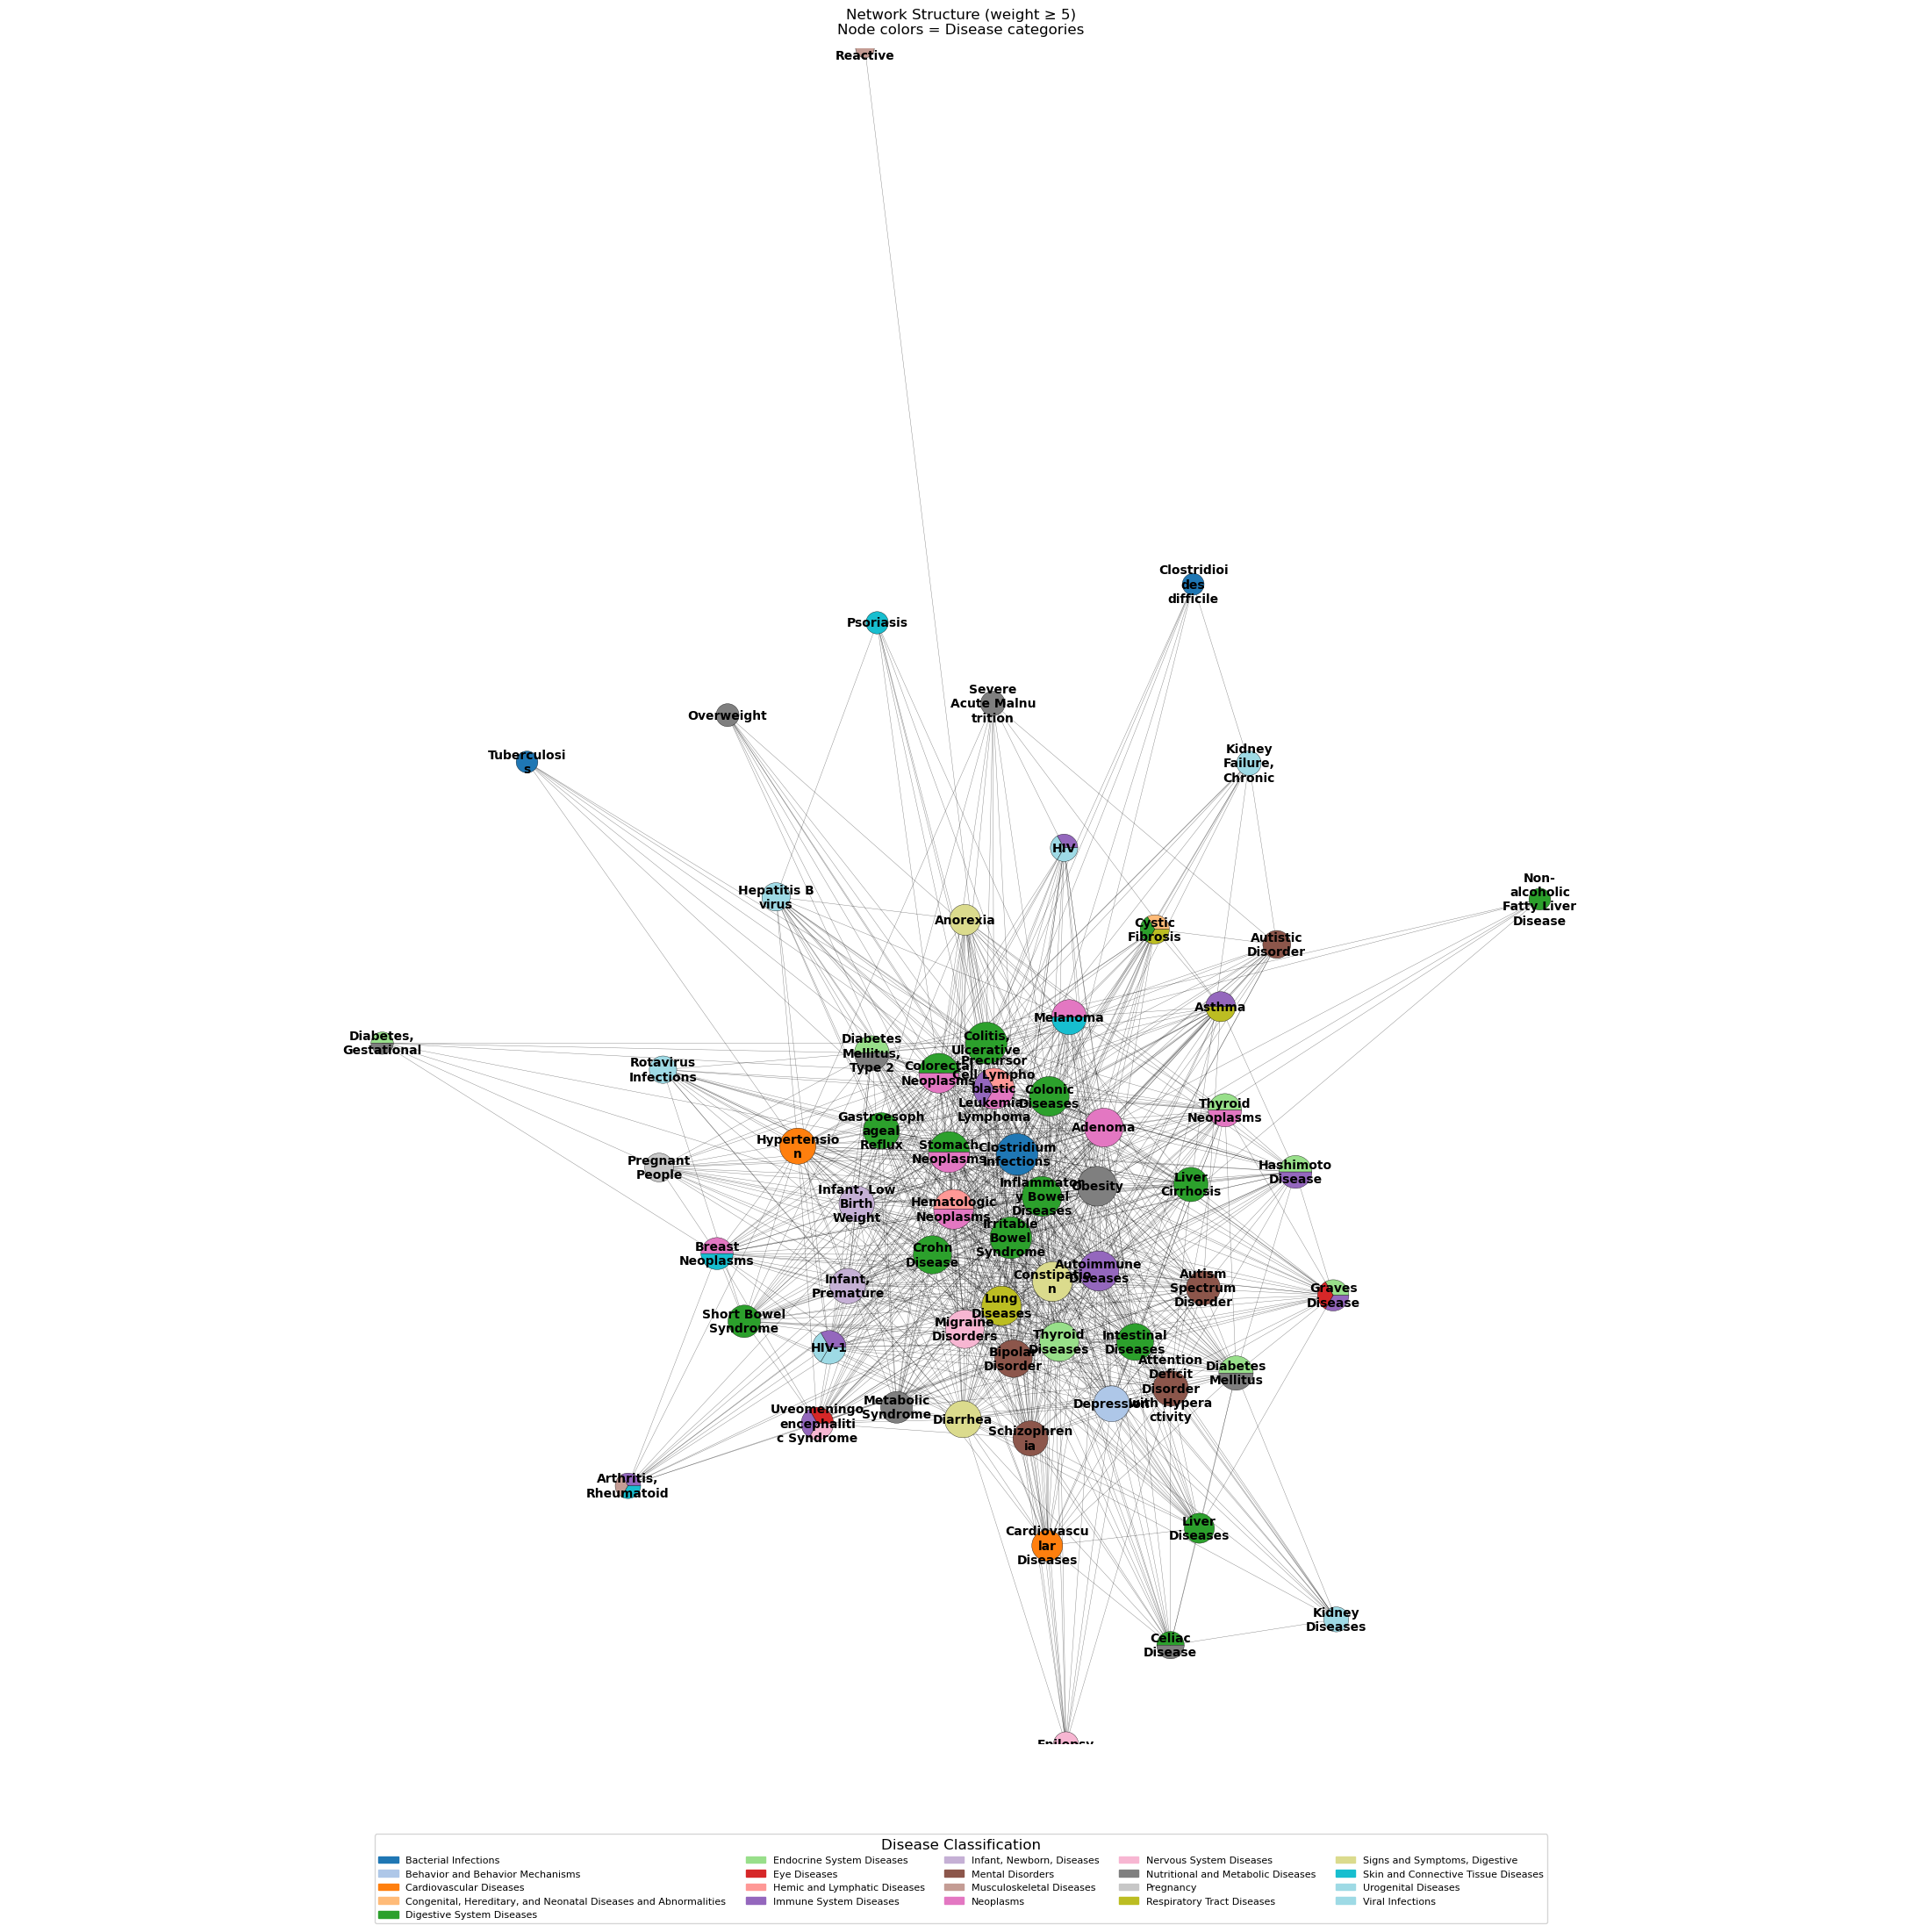

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

# --- Tunables (spacing without changing layout) ---
scale_factor = 2.0       # >1 spreads nodes apart (no layout recompute)
padding_factor = 0       # extra whitespace around the network

# --- Layout & labels (unchanged physics) ---
pos = nx.spring_layout(G_filtered, seed=42, k=2, iterations=1000)  # keep your existing layout
labels = {n: disease_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Inflate positions WITHOUT changing layout parameters ---
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

# --- Node size from degree (AFTER threshold) ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
min_size, max_size = 200, 1000  # points^2
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Normalize categories per node & collect actually used categories ---
node_cats = {}
for n in G_filtered.nodes():
    cats = disease_category_by_id.get(n, [])
    if not isinstance(cats, list) or len(cats) == 0:
        cats = ["(Unclassified)"]
    node_cats[n] = cats
used_categories = sorted({c for cats in node_cats.values() for c in cats})

# --- Color map ONLY for used categories ---
cmap = plt.cm.get_cmap("tab20", len(used_categories) if len(used_categories) > 0 else 1)
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Figure & axis ---
fig, ax = plt.subplots(figsize=(22, 22))

# Edges first
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, ax=ax)

# Set axis limits with EXTRA padding (do NOT tightly fit)
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
span_x = xs.max() - xs.min()
span_y = ys.max() - ys.min()
pad_x = span_x * padding_factor if span_x > 0 else 0.1
pad_y = span_y * padding_factor if span_y > 0 else 0.1
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)

# Keep circles round
ax.set_aspect('equal', adjustable='datalim')

# Helper: convert node size (points^2) -> radius in data units
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)          # points
    r_px = r_pts * (fig.dpi / 72.0)             # pixels
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Draw nodes as pie slices
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.25, zorder=2
        )
        ax.add_patch(wedge)

# Labels on top
import textwrap

# Wrap node labels for the plot
wrap_width = 11  # characters before wrapping
labels_wrapped = {
    n: "\n".join(textwrap.wrap(lbl, wrap_width))
    for n, lbl in labels.items()
}

# Labels on top (wrapped)
nx.draw_networkx_labels(
    G_filtered, pos,
    labels=labels_wrapped,
    font_size=10,
    font_color='black',
    font_weight='bold',
    #bbox=dict(facecolor='lightgrey', edgecolor='none', alpha=0.2, boxstyle='round,pad=0.2'),
    ax=ax
)


ax.set_title(f"Network Structure (weight ≥ {edge_weight_threshold})\nNode colors = Disease categories", pad =12)
ax.axis('off')

# Legend ONLY for used categories - horizontal at bottom
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(
    handles=legend_handles,
    title="Disease Classification",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),   # move below plot
    fancybox=True,
    shadow=False,
    ncol=min(len(used_categories), 5),  # controls columns in legend row
    fontsize=8,
    title_fontsize=12
)

plt.tight_layout()
plt.show()


In [27]:
import networkx as nx
import pandas as pd
import community as community_louvain  # Louvain community detection

# --- Helper: Get name from disease_dict if available ---
def get_name(node):
    return disease_dict.get(node, str(node))

# --- Centrality Measures ---
metrics = {}

# Degree (raw connections)
metrics['Degree'] = dict(G_filtered.degree())

# Degree Centrality (normalized by max possible degree)
metrics['Degree Centrality'] = nx.degree_centrality(G_filtered)

# Closeness Centrality (inverse of avg shortest path to all others)
metrics['Closeness Centrality'] = nx.closeness_centrality(G_filtered)

# Betweenness Centrality (how often a node is on shortest paths)
metrics['Betweenness Centrality'] = nx.betweenness_centrality(G_filtered)

# Eigenvector Centrality (importance via connected important nodes)
try:
    metrics['Eigenvector Centrality'] = nx.eigenvector_centrality(G_filtered, max_iter=1000)
except nx.NetworkXError:
    metrics['Eigenvector Centrality'] = {}

# PageRank (random walk importance)
metrics['PageRank'] = nx.pagerank(G_filtered)

# Harmonic Centrality (closeness variant that handles disconnected graphs)
metrics['Harmonic Centrality'] = nx.harmonic_centrality(G_filtered)

# --- Convert to DataFrame for easy viewing ---
df_metrics = pd.DataFrame(metrics).rename(index=get_name)

# --- Sort and print top 10 for each metric ---
for metric in metrics.keys():
    print(f"\n=== {metric} ===")
    if metric == "Degree":
        print("What it means: Number of direct connections a node has.")
    elif metric == "Degree Centrality":
        print("What it means: Fraction of all possible nodes a node is connected to.")
    elif metric == "Closeness Centrality":
        print("What it means: How close a node is to all others (higher = shorter distances).")
    elif metric == "Betweenness Centrality":
        print("What it means: How often a node acts as a bridge along the shortest path between two other nodes.")
    elif metric == "Eigenvector Centrality":
        print("What it means: Importance of a node based on being connected to other important nodes.")
    elif metric == "PageRank":
        print("What it means: Probability of landing on a node during a random walk (like Google's ranking).")
    elif metric == "Harmonic Centrality":
        print("What it means: Closeness-like measure that handles disconnected graphs better.")

    top10 = df_metrics[metric].sort_values(ascending=False).head(10)
    for name, value in top10.items():
        print(f"{name:40} {value:.4f}")

# --- Global Network Properties ---
print("\n=== Global Network Properties ===")
print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")
print(f"Density: {nx.density(G_filtered):.4f} - Fraction of possible edges present.")
print(f"Average clustering coefficient: {nx.average_clustering(G_filtered):.4f} - Tendency to form triangles.")
print(f"Transitivity: {nx.transitivity(G_filtered):.4f} - Ratio of triangles to connected triples.")

# Diameter & avg path length only if graph is connected
if nx.is_connected(G_filtered):
    print(f"Diameter: {nx.diameter(G_filtered)} - Longest shortest path.")
    print(f"Average path length: {nx.average_shortest_path_length(G_filtered):.4f} - Mean distance between nodes.")
else:
    print("Graph is disconnected: Diameter and average path length are undefined.")

# --- Community Detection (Louvain) ---
partition = community_louvain.best_partition(G_filtered)
modularity = community_louvain.modularity(partition, G_filtered)
print(f"Modularity (Louvain): {modularity:.4f} - Strength of community structure (higher = more distinct communities).")

# Print top 5 largest communities
from collections import Counter
community_counts = Counter(partition.values())
print("Top 5 community sizes:", community_counts.most_common(5))



=== Degree ===
What it means: Number of direct connections a node has.
Colitis, Ulcerative                      56.0000
Clostridium Infections                   56.0000
Irritable Bowel Syndrome                 56.0000
Stomach Neoplasms                        54.0000
Precursor Cell Lymphoblastic Leukemia-Lymphoma 53.0000
Autoimmune Diseases                      51.0000
Constipation                             50.0000
Colonic Diseases                         50.0000
Hematologic Neoplasms                    50.0000
Obesity                                  50.0000

=== Degree Centrality ===
What it means: Fraction of all possible nodes a node is connected to.
Colitis, Ulcerative                      0.9032
Clostridium Infections                   0.9032
Irritable Bowel Syndrome                 0.9032
Stomach Neoplasms                        0.8710
Precursor Cell Lymphoblastic Leukemia-Lymphoma 0.8548
Autoimmune Diseases                      0.8226
Constipation                             

In [1]:
powerlaw. __version__

NameError: name 'powerlaw' is not defined